# Impact of temporal resolution of soiling models in energy yield analysis
Monthly soiling profiles are often used in energy yield assessments to estimate the impact of dust and snow on photovoltaic (PV) system performance. However, irradiance and other inputs are provided at hourly intervals. This contradition in temporal resolution causes errors in annual energy yield predictions. This study investigates the magnitude of the error by comparing annual energy production with daily versus monthly soiling inputs. 

In [1]:
import pathlib
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import pvlib as pvl
import seaborn as sns

mpl.rcParams['figure.figsize'] = (12, 8)
sns.set(font_scale=1.5)

In [2]:
tmy3_path = pathlib.Path("C:/Users/ADMMIKM/Downloads/weather/NSRDB/1991-2005/tmy3")
alltmy3 = tmy3_path / "alltmy3a"
tmy3_stations_meta = tmy3_path / "TMY3_StationsMeta(1).csv"
tmy3_stations_meta = pd.read_csv(tmy3_stations_meta)
tmy3_stations_meta.head()


,USAF,Site Name,State,Latitude,Longitude,TZ,Elev,Class,Pool
0,690150,TWENTYNINE PALMS,CA,34.300,-116.167,-8,626,II,12
1,690190,ABILENE DYESS AFB,TX,32.433,-99.850,-6,545,II,12
2,690230,WHIDBEY ISLAND NAS,WA,48.350,-122.667,-8,10,II,12
3,699604,YUMA MCAS,AZ,32.650,-114.617,-7,65,II,12
4,700197,SELAWIK,AK,66.600,-160.000,-9,8,III,11


In [3]:
def get_soiling_profiles(tmy3df, rate=0.0010, grace=1, rainthresh=4):
    precip = tmy3df['Lprecip depth (mm)']
    soiling = pvl.soiling.kimber(
        precip, soiling_loss_rate=rate, grace_period=grace,
        cleaning_threshold=rainthresh)
    return soiling

In [73]:
def get_fixedtilt_energy(tmy3df, meta, soiling, fixed_tilt=30.0, system_azimuth=180,
                         eta=0.2, utherm=[25.0, 1.2], dc=1e6, ac=800e3, gamma=-0.004):
    times = tmy3df.index.shift(freq='-30min')
    dni = tmy3df['dni'].values
    ghi = tmy3df['ghi'].values
    dhi = tmy3df['dhi'].values
    press = tmy3df['pressure'].values * 100  # convert from mbar to Pa
    airtemp = tmy3df['temp_air'].values
    windspeed = tmy3df['wind_speed'].values
    solar_position = pvl.solarposition.get_solarposition(
        times, meta['latitude'], meta['longitude'], altitude=meta['altitude'],
        pressure=press, temperature=airtemp)
    dni_extra = pvl.irradiance.get_extra_radiation(times)
    dni_extra.name = 'dni_extra'
    poa_irradiance = pvl.irradiance.get_total_irradiance(
        surface_tilt=fixed_tilt,
        surface_azimuth=system_azimuth,
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni=dni, ghi=ghi, dhi=dhi, dni_extra=dni_extra,
        model='haydavies')
    cell_temperature = pvl.temperature.pvsyst_cell(
        poa_irradiance['poa_global'],
        temp_air=airtemp,
        wind_speed=windspeed,
        module_efficiency=eta,
        u_c=utherm[0], u_v=utherm[1])
    cell_temperature.name = 'cell_temperature'
    effective_irradiance = poa_irradiance['poa_global'] * (1-soiling.values)
    effective_irradiance.name = 'effective_irradiance'
    dc_energy = pvl.pvsystem.pvwatts_dc(
        effective_irradiance=effective_irradiance,
        temp_cell=cell_temperature, pdc0=dc, gamma_pdc=gamma)
    dc_energy.name = 'dc_energy'
    ac_energy = pvl.inverter.pvwatts(dc_energy, pdc0=ac)
    ac_energy.name = 'ac_energy'
    df = pd.concat([
        solar_position,
        dni_extra,
        poa_irradiance,], axis=1)
    df = pd.concat([df, cell_temperature,
                    effective_irradiance,
                    dc_energy,
                    ac_energy], axis=1)
    df.index = tmy3df.index
    return df

{'USAF': 690150, 'Name': '"TWENTYNINE PALMS"', 'State': 'CA', 'TZ': -8.0, 'latitude': 34.3, 'longitude': -116.167, 'altitude': 626.0}


C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_6864\2490723339.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_soil_tp = soiling_tp.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_6864\2490723339.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  monthly_soil_tp = monthly_soil_tp.resample('H').ffill().iloc[:-1]


Total AC Energy (Hourly Soiling FF): 1929883616.0321608
Total AC Energy (Monthly Soiling FF): 1931269046.4117131
Difference: -1385430.3795523643
Percentage Difference: -0.07%


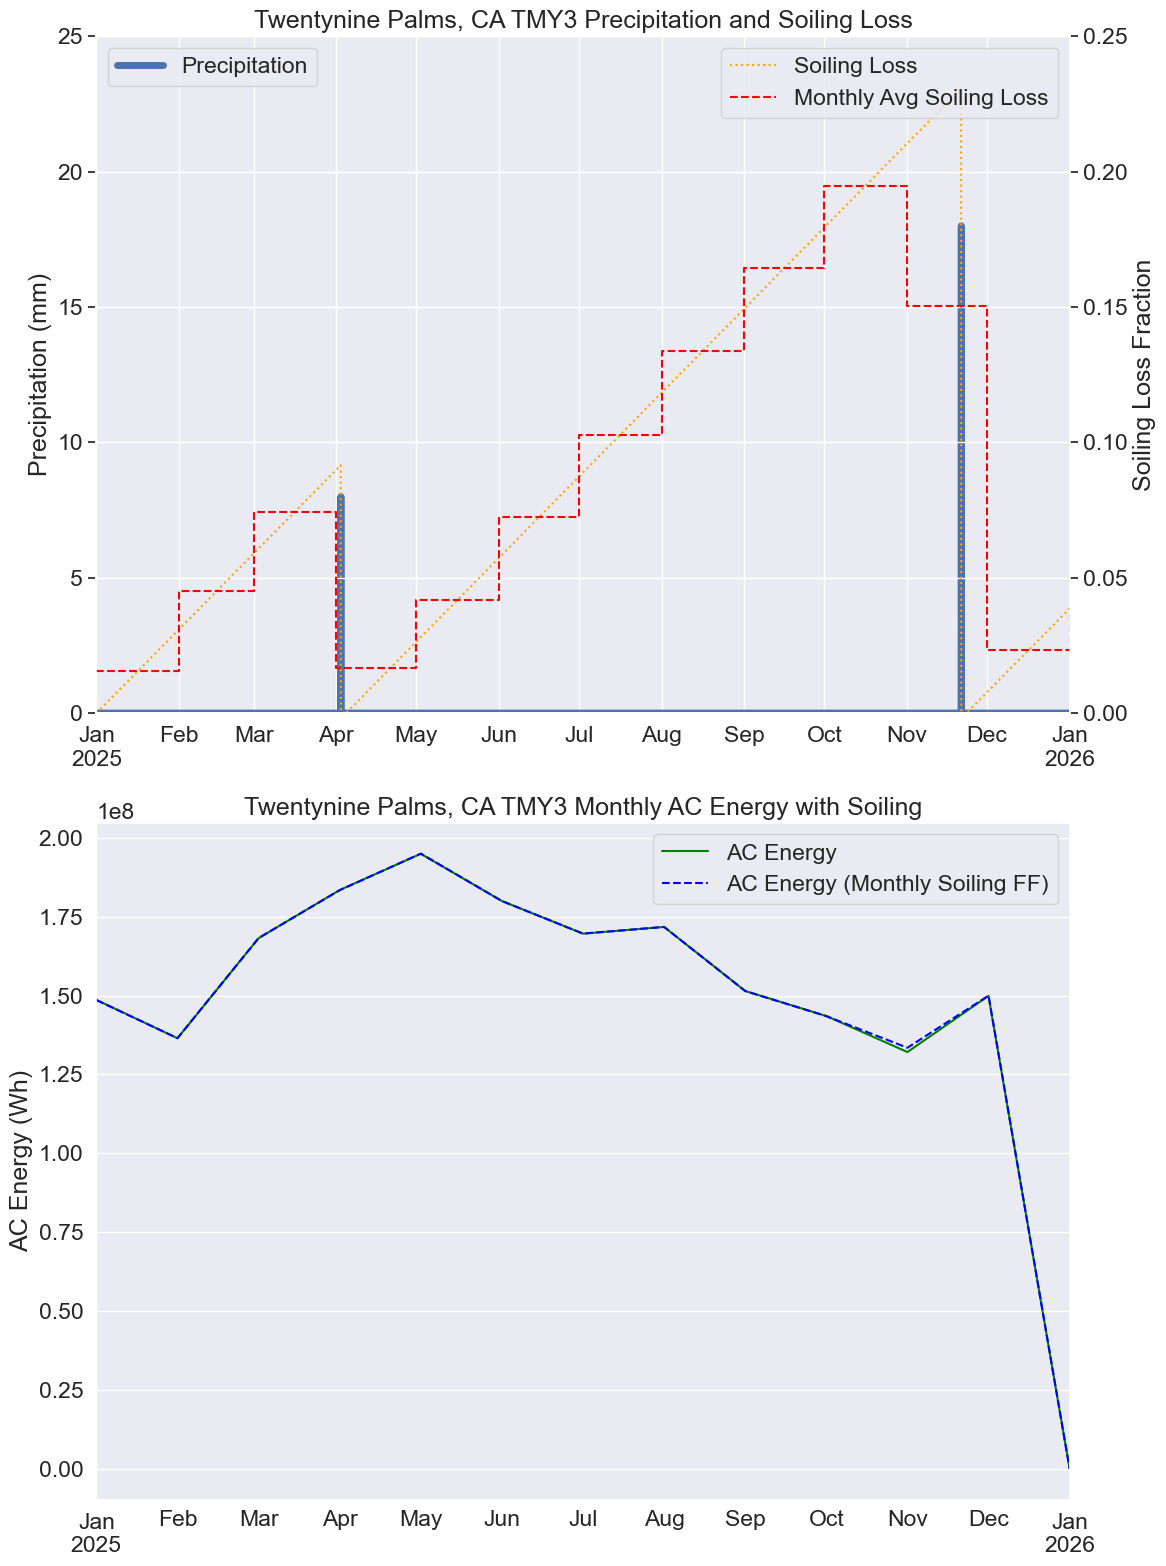

In [113]:
twentynine_palms, meta_tp = pvl.iotools.read_tmy3(
    filename=(alltmy3 / "690150TYA.CSV"),
    coerce_year=2025)

print(meta_tp)

soiling_tp = get_soiling_profiles(twentynine_palms)

fixedtilt_tp = get_fixedtilt_energy(
    twentynine_palms, meta_tp, soiling_tp)

monthly_soil_tp = soiling_tp.resample('ME').mean().shift(freq='-1M').shift(freq='1D')
monthly_soil_tp = monthly_soil_tp.resample('H').ffill().iloc[:-1]
monthly_ff_tp = get_fixedtilt_energy(
    twentynine_palms, meta_tp, monthly_soil_tp)


f, a = plt.subplots(2, 1, figsize=(12, 16))

twentynine_palms['Lprecip depth (mm)'].plot(ax=a[0], linewidth=5, label='Precipitation')
atwin = a[0].twinx()
soiling_tp.plot(
    ax=atwin, color='orange', label='Soiling Loss', linestyle=':')
soiling_tp.resample('ME').mean().plot(
    ax=atwin, color='red', linestyle='--', label='Monthly Avg Soiling Loss',
    drawstyle='steps-post')
a[0].set_title('Twentynine Palms, CA TMY3 Precipitation and Soiling Loss')
a[0].set_ylabel('Precipitation (mm)')
atwin.set_ylabel('Soiling Loss Fraction')
a[0].legend(loc='upper left')
atwin.legend(loc='upper right')
a[0].set_ylim(0, 25)
atwin.set_ylim(0, 0.25)
fixedtilt_tp['ac_energy'].resample('ME').sum().plot(
    ax=a[1], color='green', label='AC Energy')
monthly_ff_tp['ac_energy'].resample('ME').sum().plot(
    ax=a[1], color='blue', linestyle='--', label='AC Energy (Monthly Soiling FF)')
a[1].set_title('Twentynine Palms, CA TMY3 Monthly AC Energy with Soiling')
a[1].set_ylabel('AC Energy (Wh)')
a[1].legend()
f.tight_layout()

print(f"Total AC Energy (Hourly Soiling FF): {fixedtilt_tp['ac_energy'].sum()}")
print(f"Total AC Energy (Monthly Soiling FF): {monthly_ff_tp['ac_energy'].sum()}")
print(f"Difference: {fixedtilt_tp['ac_energy'].sum() - monthly_ff_tp['ac_energy'].sum()}")
print(f"Percentage Difference: {100 * (fixedtilt_tp['ac_energy'].sum() - monthly_ff_tp['ac_energy'].sum()) / fixedtilt_tp['ac_energy'].sum():.2f}%")

In [ ]:
whidbey_isle, _ = pvl.iotools.read_tmy3(
    filename=(alltmy3 / "690230TYA.CSV"),
    coerce_year=2025)

a = whidbey_isle['Lprecip depth (mm)'].plot(linewidth=5, label='Precipitation')
atwin = a.twinx()
soiling_wi = get_soiling_profiles(whidbey_isle)
soiling_wi.plot(
    ax=atwin, color='orange', label='Soiling Loss', linestyle=':')
soiling_wi.resample('ME').mean().plot(
    ax=atwin, color='red', linestyle='--', label='Monthly Avg Soiling Loss',
    drawstyle='steps-post')
a.set_title('Whidbey Island, WA TMY3 Precipitation and Soiling Loss')
a.set_ylabel('Precipitation (mm)')
atwin.set_ylabel('Soiling Loss Fraction')
a.legend(loc='upper left')
atwin.legend(loc='upper right')
a.set_ylim(0, 25)
atwin.set_ylim(0, 0.25)

In [71]:
df_tp.columns

Index(['apparent_zenith', 'zenith', 'apparent_elevation', 'elevation',
       'azimuth', 'equation_of_time', 'dni_extra', 'poa_global', 'poa_direct',
       'poa_diffuse', 'poa_sky_diffuse', 'poa_ground_diffuse',
       'cell_temperature', 'effective_irradiance', 'dc_energy', 'ac_energy'],
      dtype='object')

In [12]:
meta_tp

{'USAF': 690150,
 'Name': '"TWENTYNINE PALMS"',
 'State': 'CA',
 'TZ': -8.0,
 'latitude': 34.3,
 'longitude': -116.167,
 'altitude': 626.0}

C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_6864\3753916472.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  soiling_tp.resample('ME').mean().shift(freq='-1M').shift(freq='1D').resample('H').ffill().iloc[:-1].plot()
C:\Users\ADMMIKM\AppData\Local\Temp\2\ipykernel_6864\3753916472.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  soiling_tp.resample('ME').mean().shift(freq='-1M').shift(freq='1D').resample('H').ffill().iloc[:-1].plot()


<Axes: >

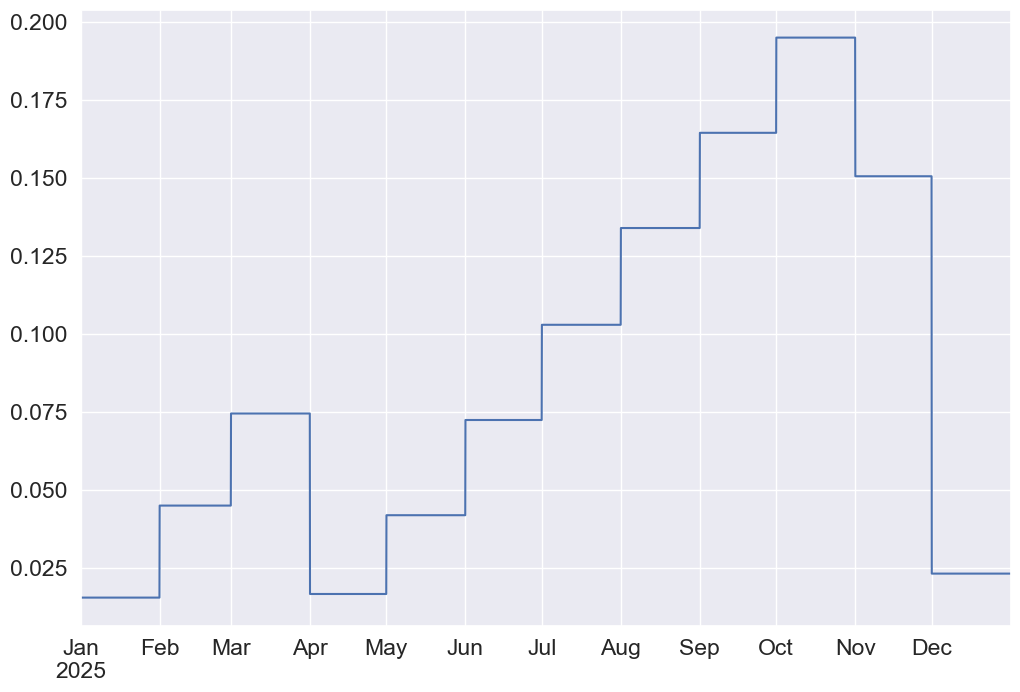

In [107]:
twentynine_palms.head()

,Date (MM/DD/YYYY),Time (HH:MM),ghi_extra,dni_extra,ghi,GHI source,GHI uncert (%),dni,DNI source,DNI uncert (%),...,albedo,Alb source,Alb uncert (code),Lprecip depth (mm),Lprecip quantity (hr),Lprecip source,Lprecip uncert (code),PresWth (METAR code),PresWth source,PresWth uncert (code)
2025-01-01 01:00:00-08:00,01/01/1998,01:00,0,0,0,2,0,0,2,0,...,0.19,F,8,0,1,D,9,0,C,8
2025-01-01 02:00:00-08:00,01/01/1998,02:00,0,0,0,2,0,0,2,0,...,0.19,F,8,0,1,D,9,0,C,8
2025-01-01 03:00:00-08:00,01/01/1998,03:00,0,0,0,2,0,0,2,0,...,0.19,F,8,0,1,D,9,0,C,8
2025-01-01 04:00:00-08:00,01/01/1998,04:00,0,0,0,2,0,0,2,0,...,0.19,F,8,0,1,D,9,0,C,8
2025-01-01 05:00:00-08:00,01/01/1998,05:00,0,0,0,2,0,0,2,0,...,0.19,F,8,0,1,D,9,0,C,8
